In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mineral-ores-around-the-world/Mineral ores round the world.csv
/kaggle/input/india-gis-data/India States/Indian_states.shp
/kaggle/input/india-gis-data/India States/Indian_states.prj
/kaggle/input/india-gis-data/India States/Indian_states.dbf
/kaggle/input/india-gis-data/India States/Indian_states.shx
/kaggle/input/india-gis-data/India Boundary/India_boundary.dbf
/kaggle/input/india-gis-data/India Boundary/India_boundary.prj
/kaggle/input/india-gis-data/India Boundary/India_boundary.shx
/kaggle/input/india-gis-data/India Boundary/India_boundary.shp
/kaggle/input/poptable/poptable.csv


In [1]:
# Experiment 7
# Use Geospatial Data Projection on datasets

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns 
import matplotlib.pyplot as plt
import geopandas as geo
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
df=pd.read_csv("../input/mineral-ores-around-the-world/Mineral ores round the world.csv")
df.head()

,site_name,latitude,longitude,region,country,state,county,com_type,commod1,commod2,...,dep_type,prod_size,dev_stat,ore,gangue,work_type,names,ore_ctrl,hrock_type,arock_type
0,Lookout Prospect,55.05612,-132.14344,NaN,United States,Alaska,NaN,M,Copper,"Gold, Silver",...,NaN,N,Occurrence,"Chalcopyrite, Covellite, Pyrite","Quartz, Sericite",NaN,"Conundrum, Mammoth, Wakefield Minerals Co.",NaN,Schist,NaN
1,Lucky Find Prospect,55.52751,-132.68514,NaN,United States,Alaska,NaN,M,Copper,Gold,...,NaN,N,Occurrence,"Chalcopyrite, Pyrite","Calcite, Quartz, Siderite",Underground,NaN,Vein Follows Contact,Diabase,NaN
2,Mccullough Prospect,55.97751,-132.99906,NaN,United States,Alaska,NaN,M,Copper,NaN,...,NaN,N,Occurrence,"Chalcopyrite, Pyrite, Sphalerite",Quartz,NaN,"Claims: Horseshoe, Copper, Lake Bay",NaN,Siltstone,NaN
3,Lucky Jim Claim,55.52195,-132.68653,NaN,United States,Alaska,NaN,M,Gold,NaN,...,NaN,N,Occurrence,"Galena, Malachite, Pyrite",NaN,NaN,NaN,NaN,Granite,Granite
4,Matilda Occurrence,55.14556,-132.05233,NaN,United States,Alaska,NaN,M,Gold,NaN,...,NaN,N,Occurrence,Pyrite,NaN,NaN,NaN,NaN,Mica Schist,NaN


In [5]:
#Our key focus is India.
india_df=df[df["country"]=="India"]
india_df=india_df.reset_index().drop(columns=["index"])
india_df.head() # taking india's ores only.
india_df["state"]=india_df['state'].replace({'Orissa': 'Odisha', 'Tamil Nadu [Madras]': 'Tamil Nadu'})

In [6]:
shp_gdf = geo.read_file('../input/india-gis-data/India States/Indian_states.shp')
gdf = geo.GeoDataFrame(
    india_df.iloc[:,:5], geometry=geo.points_from_xy(india_df.iloc[:,:5].longitude, india_df.iloc[:,:5].latitude))

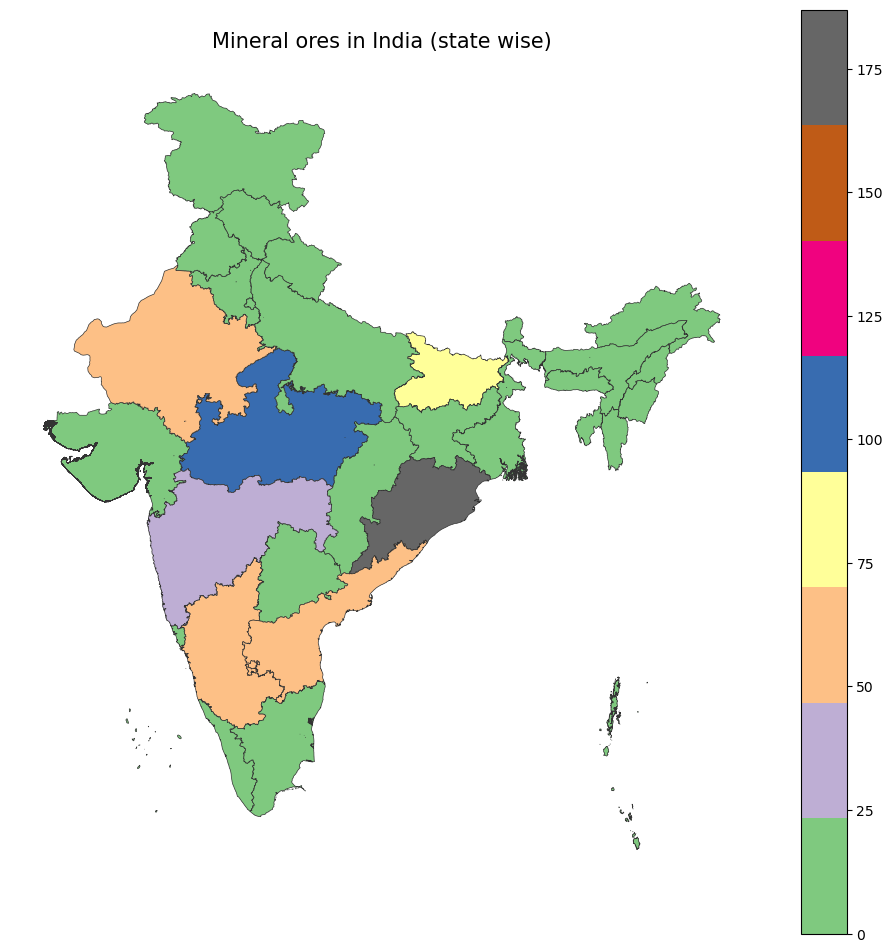

In [7]:
indian_1=india_df["state"].value_counts().to_frame()
indian_1=indian_1.reset_index().rename(columns={"index":"state","state":"mineral_ore_present"})

merged = shp_gdf.set_index('st_nm').join(indian_1.set_index('state')).fillna(0)
fig, ax = plt.subplots(1, figsize=(12, 12))
ax.axis('off')
ax.set_title('Mineral ores in India (state wise)',
             fontdict={'fontsize': '15', 'fontweight' : '3'})
fig = merged.plot(column='mineral_ore_present', cmap='Accent', linewidth=0.5, ax=ax, edgecolor='0.2',legend=True)

In [11]:
india_=india_df.loc[:,["state","commod1","commod2","commod3"]]
melted_df=pd.melt(india_, id_vars =['state'], value_vars =['commod1',"commod2","commod3"])
new_df=melted_df.drop_duplicates().dropna()[["state","value"]];
new_df1=new_df.set_index(["state"]).sort_index()
import re
new_df1["Minerals_present"]=[re.split(r"[-;,.\s]\s*", i) for i in new_df1["value"]]
new_df2=new_df1.reset_index().groupby("state")["Minerals_present"].sum()
new_df3=new_df2.to_frame().reset_index()
new_df3["Minerals_present"]=[list(set(i)) for i in new_df3["Minerals_present"]]
new_df3["Count_of_minerals"]=[len(i) for i in new_df3["Minerals_present"]]
from IPython.display import HTML
HTML(new_df3.loc[:,["state","Minerals_present"]].to_html(classes='table table-striped'))

,state,Minerals_present
0,Andhra Pradesh,"[Phosphorus, Sulfur, Lead, Barite, Refinery, Manganese, Nickel, Acid, Zinc, Aluminum, Chromium, Phosphates, Titanium, Silver, Gold, Ferrochrome, Metal, Graphite, Sulfuric, Copper, Silica, Vanadium, Refiner, Cobalt, Iron, Barium]"
1,Assam,"[Platinum, Osmium, Gold, Iridium, Copper]"
2,Bihar,"[Phosphorus, Sulfur, Lead, Uranium, Manganese, Nickel, Stone, Acid, Zinc, Molybdenum, Aluminum, Kyanite, Phosphates, Gold, Silver, Selenium, Graphite, Sulfuric, Copper, Silica, Iron]"
3,"Bihar, Orissa","[Iron, Titanium, Vanadium]"
4,Goa,"[Iron, Manganese]"
5,Gujarat,"[Phosphorus, Lead, Silica, Phosphates, Iron, Titanium, Manganese, Fluorine, Fluorite, Copper, Zinc, Aluminum]"
6,Himachal Pradesh,"[Iron, Titanium, Silica, Copper]"
7,Jammu and Kashmir,"[Sulfur, Soda, Borates, Lead, Gypsum, Ash, Anhydrite, Halite, Copper, Sodium, Sulfate, Boron]"
8,Karnataka,"[Sulfur, Chromium, Silica, Phosphorus, Zirconium, Metal, or, Ferrochrome, Phosphates, Iron, Titanium, Gold, Manganese, Garnet, Contained, Copper, Aluminum]"
9,Kerala,"[Zirconium, Phosphorus, Silica, Pigment, Kyanite, Metal, or, Thorium, Phosphates, Iron, Titanium, Garnet, Contained, REE, Zinc, Aluminum]"


In [12]:
o_gag=india_df[["state","gangue","ore"]]
o_gag=o_gag.groupby("state")["gangue","ore"].sum().reset_index().merge(new_df3,on="state")
o_gag1=o_gag.loc[:,["gangue","ore","Minerals_present"]]
o_gag1=o_gag1[o_gag1["ore"]!=0]

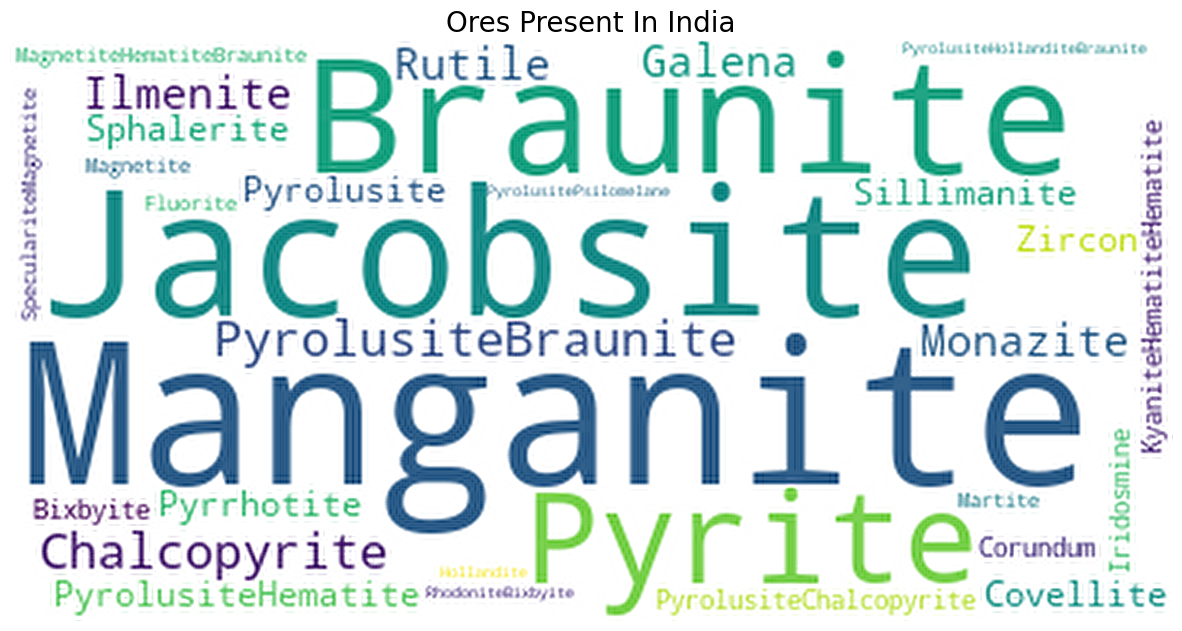

In [13]:
from PIL import Image
from io import BytesIO 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords,max_words=150,background_color="white",collocations=False,mode="RGBA").generate(' '.join(o_gag1["ore"])).to_array()
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation= 'sinc')
plt.axis("off")
plt.title("Ores Present In India",fontsize=20)
plt.show() #Ores are the those from which we get minerals.